<a href="https://colab.research.google.com/github/nnilayy/CAFA-5-Protein-Function-Prediction/blob/main/cafa_5_protein_function_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Protein-Sequences: train_sequences.fasta
# train_terms.tsv: Ground truth for the proteins in train_sequences.fasta.
    # (1)unique protein id
    # (2)GO Term id
    # (3)In which ontology the term appears

# Predict all terms/functions/GO Term IDs of protein sequences.
# One Protein Sequence can have many functions/terms
# This means that the task at hand is a multi-label classification problem.


# To train a machine learning model we cannot use the alphabetical protein sequences intrain_sequences.fasta directly.
# First Convert them into a vector format.
# In this notebook, we will use embeddings of the protein sequences to train the model.
# You can think of protein embeddings to be similar to word embeddings used to train NLP models.


# Protein embeddings Captures protein's structural and functional characteristics.
# Either train custom ML model to learn the protein embeddings of the protein sequences.
# Dataset represents proteins using amino-acid sequences which is a standard approach, Use publicly available pre-trained protein embedding models to generate the embeddings.

# used the precalculated protein embeddings created by Sergei Fironov using the Rost Lab's T5 protein language model.

# The protein embeddings to be used for training are recorded in train_embeds.npy and the corresponding protein ids are available in train_ids.npy.

# CAFA 5 protein function Prediction with TensorFlow

This notebook walks you through how to train a DNN model using TensorFlow on the CAFA 5 protein function Prediction dataset made available for this competition.

The objective of the model is to predict the function(aka **GO term ID**) of a set of proteins based on their amino acid sequences and other data.


**Note** : This notebook runs without any GPU. This is because enabling GPUs leaves less RAM memory on the VM and the submission step needs a lot of memory. One point where this would impact is when training the model. With CPU it will take around 2 minutes while on GPU it would take around 30 seconds.

## About the Data

### Protein Sequence

Each protein is composed of dozens or hundreds of amino acids that are linked sequentially. Each amino acid in the sequence may be represented by a one-letter or three-letter code. Thus the sequence of a protein is often notated as a string of letters.

<img src="https://cityu-bioinformatics.netlify.app/img/tools/protein/pro_seq.png" alt ="Sequence.png" style='width: 800px;' >

Image source - [https://cityu-bioinformatics.netlify.app/](https://cityu-bioinformatics.netlify.app/too2/new_proteo/pro_seq/)

The `train_sequences.fasta` made available for this competitions, contains the sequences for proteins with annotations (labelled proteins).

# Gene Ontology

We can define the functional properties of a proteins using Gene Ontology(GO). Gene Ontology (GO) describes our understanding of the biological domain with respect to three aspects:
1. Molecular Function (MF)
2. Biological Process (BP)
3. Cellular Component (CC)

Read more about Gene Ontology [here](http://geneontology.org/docs/ontology-documentation).

File `train_terms.tsv` contains the list of annotated terms (ground truth) for the proteins in `train_sequences.fasta`. In `train_terms.tsv` the first column indicates the protein's UniProt accession ID (unique protein id), the second is the `GO Term ID`, and the third indicates in which ontology the term appears.

# Labels of the dataset

The objective of our model is to predict the terms (functions) of a protein sequence. One protein sequence can have many functions and can thus be classified into any number of terms. Each term is uniquely identified by a `GO Term ID`. Thus our model has to predict all the `GO Term ID`s for a protein sequence. This means that the task at hand is a multi-label classification problem.

# Protein embeddings for train and test data

To train a machine learning model we cannot use the alphabetical protein sequences in`train_sequences.fasta` directly. They have to be converted into a vector format. In this notebook, we will use embeddings of the protein sequences to train the model. You can think of protein embeddings to be similar to word embeddings used to train NLP models.
<!-- Instead, to make calculations and data preparation easier we will use precalculated protein embeddings.
 -->
Protein embeddings are a machine-friendly method of capturing the protein's structural and functional characteristics, mainly through its sequence. One approach is to train a custom ML model to learn the protein embeddings of the protein sequences in the dataset being used in this notebook. Since this dataset represents proteins using amino-acid sequences which is a standard approach, we can use any publicly available pre-trained protein embedding models to generate the embeddings.

There are a variety of protein embedding models. To make data preparation easier, we have used the precalculated protein embeddings created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model in this notebook. The precalculated protein embeddings can be found [here](https://www.kaggle.com/datasets/sergeifironov/t5embeds). We have added this dataset to the notebook along with the dataset made available for the competition.

To add this to your enviroment, on the right side panel, click on `Add Data` and search for `t5embeds` (make sure that it's the correct [one](https://www.kaggle.com/datasets/sergeifironov/t5embeds)) and then click on the `+` beside it.



# Import the Required Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import progressbar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_terms=pd.read_csv('/content/drive/MyDrive/cafa-5-protein-function-prediction/Train/train_terms.tsv', sep="\t")
train_terms.head()
train_terms.shape

# Loading the protein embeddings


We will now load the pre calculated protein embeddings created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

If the `tfembeds` is not yet on the input data of the notebook, you can add it to your enviromentby clicking on `Add Data` and search for `t5embeds` (make sure that it's the correct [one](https://www.kaggle.com/datasets/sergeifironov/t5embeds) ) and then click on the `+` beside it.

The protein embeddings to be used for training are recorded in `train_embeds.npy` and the corresponding protein ids are available in `train_ids.npy`.

First, we will load the protein ids of the protein embeddings in the train dataset contained in `train_ids.npy` into a numpy array.

In [ ]:
train_protein_ids = np.load('/content/drive/MyDrive/t5embeds/train_ids.npy')
train_protein_ids_pd=pd.DataFrame(train_protein_ids)
train_protein_ids_pd.head(100)

,0
0,P20536
1,O73864
2,O95231
3,A0A0B4J1F4
4,P54366
...,...
95,A0A193H396
96,P57075
97,O22779
98,P57790


<!-- Now, we will load`train_embeds.py` which contains the pre-calculated embeddings of the proteins in the train dataset. with protein_ids (`id`s we loaded previously from the **train_ids.npy**) into a numpy array. This array now contains the precalculated embeddings for the protein_ids( Ids we loaded above from **train_ids.npy**) needed for training. -->

After loading the files as numpy arrays, we will convert them into Pandas dataframe.

Each protein embedding is a vector of length 1024. We create the resulting dataframe such that there are 1024 columns to represent the values in each of the 1024 places in the vector.

In [ ]:
train_embeddings = np.load('/content/drive/MyDrive/t5embeds/train_embeds.npy')
column_num = train_embeddings.shape[1]
train_df  = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


# Prepare the dataset

Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

First we will extract all the needed labels(`GO term ID`) from `train_terms.tsv` file. There are more than 40,000 labels. In order to simplify our model, we will choose the most frequent 1500 `GO term ID`s as labels.

Let's plot the most frequent 100 `GO Term ID`s in `train_terms.tsv`.

In [ ]:
# Extracting Go IDs
num_of_labels = 1500
labels = train_terms['term'].value_counts().index
labels=labels[:num_of_labels]
labels

Index(['GO:0005575', 'GO:0008150', 'GO:0110165', 'GO:0003674', 'GO:0005622',
       'GO:0009987', 'GO:0043226', 'GO:0043229', 'GO:0005488', 'GO:0043227',
       ...
       'GO:0034250', 'GO:0140053', 'GO:0031345', 'GO:0098802', 'GO:0045861',
       'GO:0051783', 'GO:0031674', 'GO:0001818', 'GO:0006874', 'GO:0016887'],
      dtype='object', length=1500)

Next, we will create a new dataframe by filtering the train terms with the selected `GO Term ID`s.

In [ ]:
# Extracting the dataset which contains the top 1500(labels) GO terms
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]
train_terms_updated=train_terms_updated.reset_index(drop=True)
train_terms_updated

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0044270,BPO
3,A0A009IHW8,GO:0006753,BPO
4,A0A009IHW8,GO:0044237,BPO
...,...,...,...
4420732,X5L565,GO:0003674,MFO
4420733,X5L565,GO:0016491,MFO
4420734,X5M5N0,GO:0005515,MFO
4420735,X5M5N0,GO:0005488,MFO


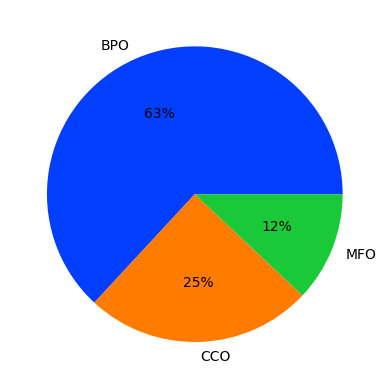

In [ ]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

As you can see, majority of the `GO term Id`s have BPO(Biological Process Ontology) as their aspect. Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0. First, we will create a numpy array train_labels of required size for the labels. To update the train_labels array with the appropriate values, we will loop through the label list.

The final labels dataframe (`label_df`) is composed of 1500 columns and 142246 entries. We can see all 1500 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [ ]:
train_size = train_protein_ids.shape[0]
train_labels = np.zeros((train_size ,num_of_labels))
series_train_protein_ids = pd.Series(train_protein_ids)

bar = progressbar.ProgressBar(maxval=num_of_labels, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
for i in range(num_of_labels):
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    label_related_proteins = n_train_terms['EntryID'].unique()
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    bar.update(i+1)
bar.finish()

labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
train_size = train_protein_ids.shape[0]
train_labels = np.zeros((train_size ,num_of_labels))
train_labels.shape

(142246, 1500)

In [ ]:
series_train_protein_ids = pd.Series(train_protein_ids)
series_train_protein_ids

0             P20536
1             O73864
2             O95231
3         A0A0B4J1F4
4             P54366
             ...    
142241    A0A286YAI0
142242    A0A1D5NUC4
142243        Q5RGB0
142244    A0A2R8QMZ5
142245    A0A8I6GHU0
Length: 142246, dtype: object

In [ ]:
bar = progressbar.ProgressBar(maxval=num_of_labels, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
for i in range(num_of_labels):
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    label_related_proteins = n_train_terms['EntryID'].unique()
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    bar.update(i+1)
bar.finish()

[============                                                            ]  17%

KeyboardInterrupt: ignored

In [ ]:
labels

Index(['GO:0005575', 'GO:0008150', 'GO:0110165', 'GO:0003674', 'GO:0005622',
       'GO:0009987', 'GO:0043226', 'GO:0043229', 'GO:0005488', 'GO:0043227',
       ...
       'GO:0034250', 'GO:0140053', 'GO:0031345', 'GO:0098802', 'GO:0045861',
       'GO:0051783', 'GO:0031674', 'GO:0001818', 'GO:0006874', 'GO:0016887'],
      dtype='object', length=1500)

In [ ]:
hello=np.array([1,2,3,4,5,6,7,8,9,10])

SyntaxError: invalid syntax (1289651752.py, line 2)

In [ ]:
train_terms_updated[train_terms_updated['term'] ==  labels[i]]

,EntryID,term,aspect
1668,A0A060XQE7,GO:0071495,BPO
2452,A0A067YMX8,GO:0071495,BPO
4404,A0A096MJY4,GO:0071495,BPO
4932,A0A097BW25,GO:0071495,BPO
6116,A0A0A7MA29,GO:0071495,BPO
...,...,...,...
2773955,Q9ZWS9,GO:0071495,BPO
2776751,S5ZH89,GO:0071495,BPO
2777515,T1SRT4,GO:0071495,BPO
2778493,U3JB00,GO:0071495,BPO


In [ ]:
label_related_proteins

array(['A0A023IM54', 'A0A068EUV3', 'A0A068F1F8', ..., 'V9VGU0', 'W7X6T2',
       'X1WE68'], dtype=object)

In [ ]:
series_train_protein_ids

0             P20536
1             O73864
2             O95231
3         A0A0B4J1F4
4             P54366
             ...    
142241    A0A286YAI0
142242    A0A1D5NUC4
142243        Q5RGB0
142244    A0A2R8QMZ5
142245    A0A8I6GHU0
Length: 142246, dtype: object

In [ ]:
series_train_protein_ids.isin(label_related_proteins)

0         False
1         False
2         False
3         False
4         False
          ...  
142241    False
142242    False
142243    False
142244    False
142245    False
Length: 142246, dtype: bool

In [ ]:
labels_df = pd.DataFrame(data = train_labels, columns = labels)
labels_df.to_csv('/kaggle/working/final_dataset/data.csv')

In [ ]:
labels_df=pd.read_csv('/content/drive/MyDrive/data.csv')
labels_df=labels_df.drop(columns='Unnamed: 0')

In [ ]:
labels_df.shape

(142246, 1500)

In [ ]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


------------------------------------------------------------------------------------------------------------------------------------------

# Training

Next, we will use Tensorflow to train a Deep Neural Network with the protein embeddings.

In [ ]:
train_df.shape

(142246, 1024)

In [ ]:
labels_df.shape

(142246, 1500)

In [ ]:
INPUT_SHAPE = [train_df.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_df,
    labels_df,
    batch_size=BATCH_SIZE,
    epochs=10
)

NameError: ignored

In [ ]:
# !mkdir model
model.save("/kaggle/working/model/model_1.h5")

# Plot the model's loss and accuracy for each epoch

<Axes: title={'center': 'Accuracy'}>

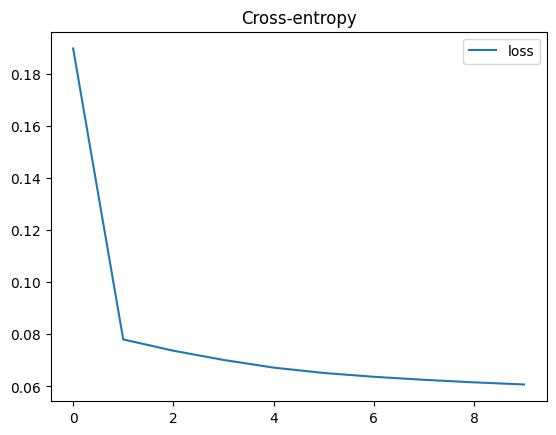

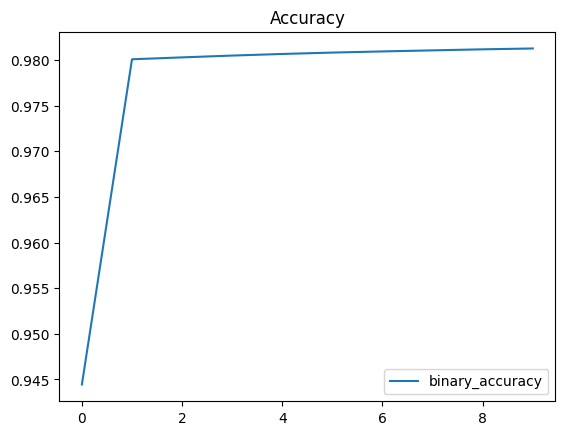

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

# Submission

For submission we will use the protein embeddings of the test data created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

In [ ]:
test_embeddings = np.load('/content/drive/MyDrive/t5embeds/test_embeds.npy')
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
test_df

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141860,0.081780,0.077098,0.006294,-0.073283,-0.064078,0.011976,0.018399,-0.102211,0.078021,0.018553,...,-0.030738,-0.039566,-0.096722,-0.127187,0.076231,0.012758,0.037633,0.005712,0.054623,0.024194
141861,0.041950,0.159886,0.033731,-0.087298,-0.002340,-0.015892,0.034585,-0.163370,-0.030956,-0.047006,...,-0.073472,-0.017192,-0.026210,-0.072754,-0.017928,-0.027033,0.030544,0.016664,0.058192,-0.004196
141862,0.032748,0.141868,0.034142,-0.063111,-0.006216,-0.025474,0.036954,-0.156333,-0.021958,-0.040103,...,-0.067549,-0.024079,-0.042062,-0.069278,-0.028636,-0.009337,0.035751,0.020646,0.054677,-0.015048
141863,0.052713,0.157013,0.043279,-0.065428,-0.010776,-0.034223,0.042106,-0.156888,-0.020948,-0.047612,...,-0.061063,-0.011962,-0.006918,-0.067281,0.026953,-0.025858,0.041463,0.021591,0.062583,-0.014903


In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/model_1.h5')
predictions =  model.predict(test_df)

In [ ]:
import pickle
file_path = '/content/drive/MyDrive/predictions'
with open(file_path, 'wb') as file:
    pickle.dump(predictions, file)

NameError: ignored

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import progressbar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_terms=pd.read_csv('/content/drive/MyDrive/cafa-5-protein-function-prediction/Train/train_terms.tsv', sep="\t")
num_of_labels = 1500
labels = train_terms['term'].value_counts().index
labels=labels[:num_of_labels]
labels

Index(['GO:0005575', 'GO:0008150', 'GO:0110165', 'GO:0003674', 'GO:0005622',
       'GO:0009987', 'GO:0043226', 'GO:0043229', 'GO:0005488', 'GO:0043227',
       ...
       'GO:0034250', 'GO:0140053', 'GO:0031345', 'GO:0098802', 'GO:0045861',
       'GO:0051783', 'GO:0031674', 'GO:0001818', 'GO:0006874', 'GO:0016887'],
      dtype='object', length=1500)

In [ ]:
import pickle
file_path = '/content/drive/MyDrive/predictions'
with open(file_path, 'rb') as file:
    predictions = pickle.load(file)

In [ ]:
predictions.shape

(141865, 1500)

In [ ]:
import pandas as pd
import numpy as np

test_protein_ids = np.load('/content/drive/MyDrive/t5embeds/test_ids.npy')
num_predictions = predictions.shape[1]
num_labels = predictions.shape[0]

data = {
    'Protein Id': pd.Series(np.repeat(test_protein_ids, num_predictions)),
    'GO Term Id': pd.Series(np.tile(labels, num_predictions)),
    'Prediction': pd.Series(predictions.ravel())
}

df_submission = pd.DataFrame(data)
df_submission.to_csv("submission.tsv",sep="\t")


From the predictions we will create the submission data frame.

**Note**: This will take atleast **15 to 20** minutes to finish.

In [ ]:
predictions.ravel()

In [ ]:
df_submission